# Random trading strategy example

This dummy example demonstrates how to backtest a simple random trading strategy
using synthetic data generated in the script.
The price series is a random walk with a drift of 0.1 and initial price 1000.

The strategy randomly buys or sells an instrument with a probability of 1%.
Buy and sell orders use the same price series, implying a spread of 0.
Each trade is executed at a commission of 0.1%.
For the sake of illustration, only 75% of the order quantity is filled.

The account equity and drawdowns are collected for every hour
and plotted at the end using the Plots package.

In [1]:
using Fastback
using Dates
using Random

# set RNG seed for reproducibility
Random.seed!(42);

# generate synthetic hourly price series
N = 2_000;
prices = 1000.0 .+ cumsum(randn(N) .+ 0.1);
dts = map(x -> DateTime(2020, 1, 1) + Hour(x), 0:N-1);

# create trading account with $10'000 start capital (margin-enabled for shorting)
acc = Account(;
    funding=AccountFunding.Margined,
    base_currency=CashSpec(:USD),
    broker=FlatFeeBroker(; pct=0.001), # 0.1% commission
);
usd = cash_asset(acc, :USD)
deposit!(acc, :USD, 10_000.0);

# register a dummy instrument
DUMMY = register_instrument!(acc, spot_instrument(Symbol("DUMMY/USD"), :DUMMY, :USD))

# data collector for account equity and drawdowns (sampling every hour)
collect_equity, equity_data = periodic_collector(Float64, Hour(1));
collect_drawdown, drawdown_data = drawdown_collector(DrawdownMode.Percentage, Hour(1));

# loop over price series
for (dt, price) in zip(dts, prices)
    # randomly trade with 1% probability
    if rand() < 0.01
        quantity = rand() > 0.4 ? 1.0 : -1.0
        order = Order(oid!(acc), DUMMY, dt, price, quantity)
        fill_order!(acc, order; dt=dt, fill_price=price, bid=price, ask=price, last=price, fill_qty=0.75order.quantity)
    end

    # update position and account P&L
    update_marks!(acc, DUMMY, dt, price, price, price)

    # collect data for plotting
    if should_collect(equity_data, dt)
        equity_value = equity(acc, usd)
        collect_equity(dt, equity_value)
        collect_drawdown(dt, equity_value)
    end
end

# print account summary
show(acc)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ ACCOUNT SUMMARY ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cash balances (1)
┌─────┬─────────┐
│     │   Value │
├─────┼─────────┤
│ USD │ 4509.06 │
└─────┴─────────┘

Equity balances (1)
┌─────┬──────────┐
│     │    Value │
├─────┼──────────┤
│ USD │ 10409.78 │
└─────┴──────────┘

Positions (1)
┌───────────┬──────┬──────────┬─────┬────────┐
│    Symbol │  Qty │ Entry px │ Ccy │    P&L │
├───────────┼──────┼──────────┼─────┼────────┤
│ DUMMY/USD │ 5.25 │  1068.10 │ USD │ 293.20 │
└───────────┴──────┴──────────┴─────┴────────┘

Trades (23)
┌────┬───────────┬─────────────────────┬───────┬────────┬─────────┬────┬────┬─────┬──────────┬─────────┬────────────────┬──────────────┬───────┐
│ ID │    Symbol │                Date │   Qty │ Filled │   Price │ TP │ SL │ Ccy │ Fill P&L │  Cash Δ │ Return (gross) │ Return (net) │ Comm. │
├────┼───────────┼─────────────────────┼───────┼────────┼──────

### Plot account equity curve

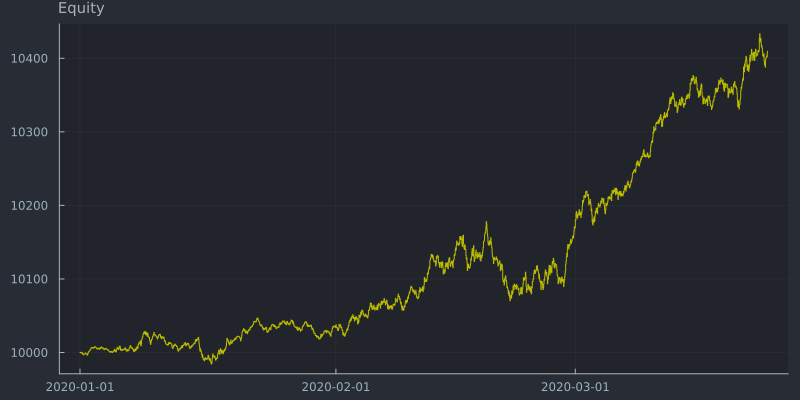

In [2]:
using Plots

theme(:juno);

Fastback.plot_equity(equity_data, size=(800, 400))

### Plot account equity drawdowns

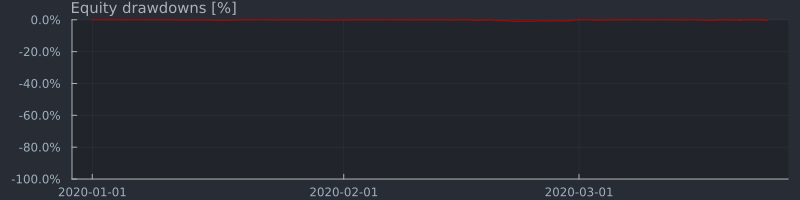

In [3]:
Fastback.plot_drawdown(drawdown_data, size=(800, 200),)

### Summary performance table

In [4]:
performance_summary_table(equity_data; periods_per_year=365 * 24)

Row,cagr,vol,sharpe,sortino,max_dd,mar,calmar
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.192428,0.031832,5.54473,8.33658,0.0105797,0.0,18.1885
